# 2 Context-Free Languages

----
## 2.1 Context-free Grammars

### Formal definition of a context-free grammar

$G = (V,\Sigma,R,S)$

$\Gamma = V\cup\Sigma$

$u\Rightarrow w$라는 derivation은
$u=v_1 A v_2$ 에 규칙 $A\to w \in R$를 적용해 $v=v_1 w v_2$를 얻을 수 있음을 뜻한다.
($u,v,w,v_1,v_2\in \Gamma^*$, $A\in V$)

$G$가 만들어내는 언어는 $\{ w \mid w\in\Sigma^*, S\Rightarrow^*w \}$

### Examples of context-free grammars

### Designing context-free grammars

### Ambiguity


In [1]:
type Gamma = String
type GString = [Gamma]

newtype CFG = CFG ([Gamma],[Gamma],[Rule],Gamma) deriving Show

data Rule = Gamma :-> GString deriving (Eq,Ord,Show)

In [2]:
-- 교과서에 나오는 G3 문법
cfgG3 = CFG (["S"],["a","b"],rs,"S")
  where
  rs = [ "S" :-> ["a","S","b"]
       , "S" :-> ["S","S"]
       , "S" :-> []
       ]

In [3]:
import Data.List

zip (inits [1,2,3,4]) (tails [1,2,3,4])

[([],[1,2,3,4]),([1],[2,3,4]),([1,2],[3,4]),([1,2,3],[4]),([1,2,3,4],[])]

In [4]:
step (CFG(vs,as,rs,_)) gs = -- any step
  [ gsL++gs'++gsR | (gsL, v : gsR) <- zip (inits gs) (tails gs),
                    v `elem` vs, -- v 가 variable 이기만 하면 됨
                    (v' :-> gs') <- rs, v==v' ]

lstep (CFG(vs,as,rs,_)) gs = -- leftmost step
  [ gsL++gs'++gsR | (gsL, v : gsR) <- zip (inits gs) (tails gs),
                    all (`elem` as) gsL, v `elem` vs, -- v는 가장 왼쪽의 variable
                    (v' :-> gs') <- rs, v==v' ]

In [5]:
mapM_ print $ step cfgG3 ["a","S","S","b"]

["a","a","S","b","S","b"]
["a","S","S","S","b"]
["a","S","b"]
["a","S","a","S","b","b"]
["a","S","S","S","b"]
["a","S","b"]

In [6]:
mapM_ print $ lstep cfgG3 ["a","S","S","b"]

["a","a","S","b","S","b"]
["a","S","S","S","b"]
["a","S","b"]

In [7]:
-- derivation step operator
infixl 5 .=> 
(.=>) :: [GString] -> GString -> [GString]
gss .=> gs = gss++[gs]

derivation = (:[])

-- valid derivation judgement
infix 4 |-
(|-) :: CFG -> [GString] -> Bool
cfg |- gss
 | length gss < 2 = error "derivation must have at least one step"
 | otherwise = and [gs2 `elem` step cfg gs1 | (gs1,gs2) <- zip gss (tail gss)]
 
 -- valid leftmost derivation judgement
infix 4 ||-
(||-) :: CFG -> [GString] -> Bool
cfg ||- gss
 | length gss < 2 = error "derivation must have at least one step"
 | otherwise = and [gs2 `elem` lstep cfg gs1 | (gs1,gs2) <- zip gss (tail gss)]

In [8]:
derivation ["S"] .=> ["a","S","b"] .=> ["a","b"]

[["S"],["a","S","b"],["a","b"]]

In [9]:
cfgG3 |- derivation ["S"]

: 

In [10]:
cfgG3 |- derivation ["S"] .=> ["a","S","b"]
cfgG3 |- derivation ["S"] .=> ["a","S","b"] .=> ["a","b"]
cfgG3 |- derivation ["S"] .=> ["a","S","b"] .=> ["a","S","b"]
cfgG3 |- derivation ["S"] .=> ["a","S","b"] .=> ["a","S","S","b"]

True

True

False

True

In [11]:
cfgG3 |- derivation ["S"] .=> ["a","S","b"]
                          .=> ["a","S","S","b"]
                          .=> ["a","S","a","S","b","b"]
                          
cfgG3||- derivation ["S"] .=> ["a","S","b"]
                          .=> ["a","S","S","b"]
                          .=> ["a","S","a","S","b","b"]

True

False

In [12]:
-- G3 is an ambiguous CFG because multiple leftmost derivation exists for S =>* ab
cfgG3||- derivation ["S"] .=> ["a","S","b"]
                          .=> ["a","b"]

cfgG3||- derivation ["S"] .=> ["a","S","b"]
                          .=> ["a","S","S","b"]
                          .=> ["a","S","b"]
                          .=> ["a","b"]

True

True

In [13]:
-- 그냥 parse tree가 유일하면 ambiguous하지 않음
import Data.Tree
-- data Tree a = Node a [a] -- 첫번째 rootLabel 두번째 subForest

tree1 =
  Node "S" [ Node "a" [] -- terminal은 자녀 없음
           , Node "S" [] -- epsilon
           , Node "b" [] -- terminal은 자녀 없음
           ]

putStrLn $ drawTree tree1

S
|
+- a
|
+- S
|
`- b

In [14]:
tree2 =
  Node "S" [ Node "a" [] -- terminal은 자녀 없음
           , Node "S" [ Node "S" [] -- epsilon
                      , Node "S" [] -- epsilon
                      ]
           , Node "b" [] -- terminal은 자녀 없음
           ]

putStrLn $ drawTree tree2

S
|
+- a
|
+- S
|  |
|  +- S
|  |
|  `- S
|
`- b

### Chomsky normal form
CFG 규칙에 $A \to BC$와 $A\to a$의 형태($B$와 $C$는 시작 변수 아님)만 있으면 촘스키정규형(CNF)이라 한다.<br>
단, $\varepsilon$을 포함하는 언어 정의도 가능해야 하므로, 예외적으로 시작 변수 $S$에 대해서만 $S\to \varepsilon$ 규칙을 허용한다.

모든 문맥자유언어(CFL)를 CNF로 나타낼 수 있다는 성질이 알려져 있다.<br>
이는 모든 문맥자유문법(CFG)을 똑같은 언어를 생성하는 CNF로 변환 가능함을 보임으로써 증명 가능하다.

기본적인 아이디어는

 * $A\to \varepsilon$ 형태의 $\varepsilon$규칙과 $A\to B$ 형태의 unit규칙을 제거하고 
 * 그런 형태의 규칙들이 만들어내던 문자열을 CNF를 만족하는 다른 규칙들로 만들어내도록

대체하는 방법만 찾아내면 된다.
그 외에 좀더 고치기 쉬운 형태의 규칙들,<br>
예를 들면 $A \to B_1 B_2 C_1 C_2$는
새로운 변수 $B_0$와 $C_0$를 도입해 아래 규칙들로 대체하면 된다.

  $A\to B_0C_0$<br>
  $B_0\to B_1 B_2$<br>
  $C_0\to C_1 C_2$

CNF가 이론을 전개하고 특정 알고리듬을 설명하는 데 요긴하게 쓰인다.<br>
그러나 CNF를 최소화된 혹은 최적화된 문법규칙이라 말할 수는 없다.<br>
CFG에는 최소화된 문법이라는 개념이 일반적으로 잘 정의되지 않는다.<br>
(참고로, 결정적유한오토마타(DFA)의 경우에는 상태 개수라는 명확한 기준으로 최소화된 DFA로 변환하는 것이 가능)

----
## 2.2 Pushdown Automata

### Pushdown Automata

### Formal definition of a pushdown automaton

$M = (Q,\Sigma,\Gamma,\delta,q_0,F)$

1. $Q$는 상태의 유한집합
1. $\Sigma$는 입력 알파벳 (입력 문자열을 구성하는 심볼의 유한집합)
1. $\Gamma$는 스택 알파벳 (스택에 저장될 수 있는 심볼의 유한집합)
1. $\delta : Q\times \Sigma_\varepsilon \times \Gamma_\varepsilon \to \wp(Q\times \Gamma_\varepsilon)$는 전이함수
1. $q_0\in Q$는 시작상태
1. $F\subseteq Q$는 받아들여지는 상태(accept state) 혹은 종료 상태(final state)라도도 한다

꼭 그렇게 해야만 하는 것은 아니지만 대부분의 경우 $\Sigma$ 전체 혹은 $\Sigma$의 부분집합을 $\Gamma$가 포함하는 경우가 많다.<br>
포함해 놓고도 전이함수에서 사용을 안하면 (그러니까 결과로 공집합을 계산하면) 되니까 그냥 많은 경우 $\Sigma \subset \Gamma$라고 생각하고 설계해도 된다.<br>
저 앞에서 CFG를 설명할 때 $\Gamma = \Sigma \cup V$ 라고 한 $\Gamma$라는 기호를 사용했던 것이 바로 이러한 맥락에서다.<br>
앞으로 배울 PDA관련 절에서 CFG를 PDA로 옮길 때 대략 스택 심볼에 $\Sigma \cup V$를 포함하게 설계하면 되기 때문에 ...


$w = w_1w_2\cdots w_m$을 (단, $w_i\in \Sigma_\varepsilon$) PDA가 받아들인다는 뜻은<br>
일련의 상태 $r_0,r_1,\ldots,r_m \in Q$와 일련의 스택 $s_0,s_1,\ldots,s_m\in\Gamma^*$가 있어<br>
다음과 같이 계속해서 전이함수를 따라가다 보면 종료상태에서 끝나는 경로가 하나라도 존재한다는 의미이다.<br>
단, 초기 상태 $r_0 = q_0$이고 초기 스택 $s_0 = \varepsilon$로 시작한다.

$\exists (r_1,b_1) \in\delta(r_0,w_1,b_0)$ 단, $s_0 = b_0 t_1, s_1 = b_1 t_1$

$\exists (r_2,b_2) \in\delta(r_1,w_2,b_1)$ 단, $s_0 = b_1 t_2, s_2 = b_2 t_2$ 

$\vdots$

$\exists (r_m,b_m) \in\delta(r_{m-1},w_m,b_{m-1})$ 단, $s_m = b_{m-1} t_m, s_m = b_m t_m$

마지막 상태 $r_m\in F$. (위에서 $b_i \in \Gamma_\varepsilon$, $t_i\in\Gamma^*$)

### Examples of pushdown automata

책에 나온 대로 위와 같이 작성한 것은 NFA랑 최대한 비슷하게 이해를 돕고자 함이다.<br>
하지만 비결정적으로라도 저런 식으로 계산을 진행하는 것은 번거롭다.<br>
그래서 PDA 상태와 스택을 한 덩어리로 묶어 종합적인 PDA의 상태로 생각하는 것이 편하다.<br>
그리고 비결정적 계산이므로 종합적인 PDA상태의 집합에서 집합으로 가는 함수를 만들어 활용한다.<br>
즉, $\delta$로부터 아래와 같은 $\hat\delta : \wp(Q\times \Gamma^*) \times \Sigma_\varepsilon \to \wp(Q\times \Gamma^*)$ 함수를 만들어 계산하자는 이야기.

$\hat\delta(C,x) = \{ (r',b't) \mid (r,bt)\in C, (r',b't)\in\delta(r,x,b) \}$

그리고 이것을 더 편하게 하기 위해 $\delta$로부터 $\delta': Q\times \Sigma_\varepsilon \times \Gamma^* \to \wp(Q\times \Gamma^*)$ 함수를 만들어 아래와 같이 정의할 수 있다.

$\hat\delta(C,z) = \{ (r',s') \mid (r,s)\in C, (r',s')\in\delta'(r,z,s) \}$

위와 같이 정의한 $\hat\delta$를 이용하면 입력 문자열 $w=w_1 \ldots w_m$이 이렇게 표현할 수 있다

$\exists (r_m, s_m) \in \hat\delta(\ldots(\hat\delta(\hat\delta(\{(r_0,s_0)\},w_1),w_2),\ldots),w_m)$ such that $r_m\in F$

이와 같은 계산 패턴은 함수형 프로그래밍에서 foldl에 해당한다.

In [15]:
import Data.List (union)

-- see p. 113 Definition 2.13
newtype PDA q a = PDA ([q], [a], [a], (q,[a],[a])->[(q,[a])], q, [q])
-- 사실상 a = String인 경우만을 활용할 것이다

-- 주어진 PDA의 delta hat 함수
stepPDA :: (Eq q, Eq a) => PDA q a -> [(q,[a])] -> [a] -> [(q,[a])]
stepPDA (PDA(qs,as,gs,d,q0,fs)) cs z = [ (r',s') | (r,s) <- cs, (r',s') <- d'(r,z,s)]
  where
  d'(r,x,g:gs) = [ (r',b'++gs)   | (r',b') <- d(r,x,[g]) ] -- b==[g], t==gs
         `union` [ (r',b'++g:gs) | (r',b') <- d(r,x,[] ) ] -- b==[], t==g:gs
  d'(r,x,[]) = d(r,x,[])

In [16]:
pdaM1 = PDA (["q1","q2","q3","q4"],["0","1"],["0","$"],d,"q1",["q1","q4"])
  where
  d("q1",[]   ,[]   ) = [("q2",["$"])]
  d("q2",["0"],[]   ) = [("q2",["0"])]
  d("q2",["1"],["0"]) = [("q3",[]   )]
  d("q3",["1"],["0"]) = [("q3",[]   )]
  d("q3",[]   ,["$"]) = [("q4",[]   )]
  d(_   ,_    ,_    ) = []

In [17]:
-- for input string 0011 = ε0011ε
stepPDA pdaM1 [("q1",[]   )]         []
stepPDA pdaM1 [("q2",["$"])]         ["0"]
stepPDA pdaM1 [("q2",["0","$"])]     ["0"]
stepPDA pdaM1 [("q2",["0","0","$"])] ["1"]
stepPDA pdaM1 [("q2",["0","$"])]     ["1"]
stepPDA pdaM1 [("q3",["$"])]         []

[("q2",["$"])]

[("q2",["0","$"])]

[("q2",["0","0","$"])]

[("q3",["0","$"])]

[("q3",["$"])]

[("q4",[])]

In [18]:
foldl (stepPDA pdaM1) [("q1",[])] [ [], ["0"], ["0"], ["1"], ["1"], [] ]

[("q4",[])]

foldl로 하니까 좀 간편하지긴 했는데 그래도 입력 문자열을 처리하는 도중에 어디서 $\varepsilon$을 얼마만큼 넣을 것인가를 잘 생각해서 필요한 곳에 추가해 주어야 한다.

NFA에서는 간단하게 입력 문자열에서의 $\varepsilon$을 처리했던 거 같은더 PDA는 그렇게 안 될까?
NFA만큼 간단하지는 않다.<br>
입력 문자열 $\varepsilon$처리와 함께 스택에도 변화가 일어날 수 있기 때문에 스택이 변화하는 가능성까지를 모두 고려해애 하기 때문이다.<br>
즉, 입력 문자열 도중의 어떤 시점에 $\varepsilon$을 임의의 개수 활용했을 때 스택을 포함한 종합적인 PDA상태의 closure가 생긴다는 보장이 없다.<br>
예를 들어 입력 문자열에 어떤 $\varepsilon$ 처리를 할 때마다 스택에 무엇인가 쌓는다고 하면 회수를 반복할수록 계속 전에 보지 못했던 다른 스택이 만들어지게 된다.

### Equivalence with context-free grammars

CFG를 PDA로 변환하는 예제를 하나만 살펴보자. (반대로 하는 것은 시간상 수업에서는 다루지 못하고 넘어간다.)

Example 2.25

* 규칙 S1: $S \to \mathtt{a}T\mathtt{b}$
* 규칙 S2: $S \to \mathtt{b}$
* 규칙 T1: $T \to T\mathtt{a}$
* 규칙 T2: $T \to \varepsilon$

길이 $n \ge 2$인 intermediate string을 생성하는 규칙마다 $n-1$개의 추가 상태 필요. (규칙 S1, T1)

길이 $n \le 1$인 intermediate string을 생성하는 규칙에는 추가 상태 필요 없음. (규칙 S2, T2)

(저 위의 CFG 프로그램에서는 intermediat string에 해당하는 것을 GString이라는 타입 별명으로 부름)

In [19]:
cfgG1 = CFG (["S","T"],["a","b"],rs,"S")
  where
  rs = [ "S" :-> ["a","T","b"]
       , "S" :-> ["b"]
       , "T" :-> ["T","a"]
       , "T" :-> []
       ]

In [20]:
cfgG1||- derivation
           ["S"] .=> ["b"]

True

In [21]:
cfgG1||- derivation
           ["S"] .=> ["a","T","b"]
                 .=> ["a","T","a","b"]
                 .=> ["a","a","b"]

True

In [22]:
cfgG1||- derivation
           ["S"] .=> ["a","T","b"]
                 .=> ["a","a","T","b"]
                 .=> ["a","a","b"]

False

In [23]:
pdaP1 = PDA ( ["q0","qS","qL","qA", "qS1b","qS1T", "qT1a"]
            , ["a","b"] -- Σ
            , ["a","b","$","S","T"] -- Γ = Σ ⋃ { $ } ⋃ V
            , d
            , "q0"
            , ["qA"] )
  where
  d("q0",[]   ,[]   ) = [("qS",["$"])]
  d("qS",[]   ,[]   ) = [("qL",["S"])]
  -- CFG production rules
  d("qL"  ,[] ,["S"]) = [("qS1b",["b"])  -- S -> a T;b
                        ,("qL"  ,["b"])] -- S ->.b
  d("qS1b",[] ,[]   ) = [("qS1T",["T"])] -- S -> a;T b
  d("qS1T",[] ,[]   ) = [("qL"  ,["a"])] -- S ->.a T b
  d("qL"  ,[] ,["T"]) = [("qT1a",["a"])  -- T -> T;a
                        ,("qL"  ,[]   )] -- T ->.ε
  d("qT1a",[] ,[]   ) = [("qL"  ,["T"])] -- T ->.T a
  -- pop terminal on the stack
  d("qL",["a"],["a"]) = [("qL",[]   )]
  d("qL",["b"],["b"]) = [("qL",[]   )]
  -- to accept state
  d("qL",[]   ,["$"]) = [("qA",[]   )]
  -- default
  d(_,_,_) = []

In [24]:
-- aab = εεεεεaεεεεabε
stepPDA pdaP1 [("q0",[])]                 []
stepPDA pdaP1 [("qS",["$"])]              []
stepPDA pdaP1 [("qL",["S","$"])]          []
stepPDA pdaP1 [("qS1b",["b","$"])
              ,("qL",["b","$"])]          []
stepPDA pdaP1 [("qS1T",["T","b","$"])]    []
stepPDA pdaP1 [("qL",["a","T","b","$"])]  ["a"]
stepPDA pdaP1 [("qL",["T","b","$"])]      []
stepPDA pdaP1 [("qT1a",["a","b","$"])
              ,("qL",["b","$"])]          []
stepPDA pdaP1 [("qL",["T","a","b","$"])]  []
stepPDA pdaP1 [("qT1a",["a","a","b","$"])
              ,("qL",["a","b","$"])]      ["a"]
stepPDA pdaP1 [("qL",["b","$"])]          ["b"]
stepPDA pdaP1 [("qL",["$"])]              []

[("qS",["$"])]

[("qL",["S","$"])]

[("qS1b",["b","$"]),("qL",["b","$"])]

[("qS1T",["T","b","$"])]

[("qL",["a","T","b","$"])]

[("qL",["T","b","$"])]

[("qT1a",["a","b","$"]),("qL",["b","$"])]

[("qL",["T","a","b","$"])]

[("qT1a",["a","a","b","$"]),("qL",["a","b","$"])]

[("qL",["b","$"])]

[("qL",["$"])]

[("qA",[])]

----
## Non-context-free Languages

### The pumping lemma for context-free languages

----
## Deterministic Context-Free Languages

DPDA는 PDA에서 전이함수 함수의 결과를 1개 이하로 강제하며 추가로 입력 및 스택에 대한 $\varepsilon$ 처리의 비결정성을 제한한다.<br>
책에서는 $\delta : Q\times \Sigma_\varepsilon \times \Gamma_\varepsilon \to (Q\times \Gamma_\varepsilon)\cup\{\emptyset\}$으로
전이함수 결과를 1개 이하로 강제함으로 표현하며,<br>
추가적인 제한사항이란 모든 $q\in Q$, $a\in\Sigma$, $x\in\Gamma$에 대해
$\delta(q,a,x)$, $\delta(q,a,\varepsilon)$, $\delta(q,\varepsilon,x)$, $\delta(q,\varepsilon,\varepsilon)$중
딱 한개씩만 $\emptyset$이 아니어야 한다.<br>
이 추가적인 제한사항은 입력이나 스택의 $\varepsilon$인 경우 전이가 $\varepsilon$이 아닌 경우의 전이를 선택하는 것과 비결정적인 상황이 발생하는 것을 방지하려는 것이다.


DPDA는 정의 자체로는 유한한 실패(finite failure)를 보장하지는 않는다. ($\varepsilon$입력을 무한히 처리하며 더 이상의 입력 문자열을 처리를 진행하지 못하는 경우 발생 가능)

In [25]:
{- -- 0^n1^n인 언어를 정의하는 저 위의 PDA M1 정의를 그대로 가져왔다
pdaM1 = PDA (["q1","q2","q3","q4"],["0","1"],["0","$"],d,"q1",["q1","q4"])
  where
  d("q1",[]   ,[]   ) = [("q2",["$"])]
  d("q2",["0"],[]   ) = [("q2",["0"])]
  d("q2",["1"],["0"]) = [("q3",[]   )]
  d("q3",["1"],["0"]) = [("q3",[]   )]
  d("q3",[]   ,["$"]) = [("q4",[]   )]
  d(_   ,_    ,_    ) = []
-}

PDA(qs,as,gs,d,q0,fs) = pdaM1

-- d가 계산한는 집합 크기를 각각 알아보면 모두 1 이하이다
[length(d(q,[a],[x])) | q<-qs, a<-as, x<-gs] ++
  [length(d(q,[a],[])) | q<-qs, a<-as] ++
  [length(d(q,[],[x])) | q<-qs, x<-gs] ++
  [length(d(q,[],[] )) | q<-qs]

putStr "=============="

-- 그러나 추가적인 조건을 알아보면 모두 1이어야 하는데 0인 것들이 있다
mapM_ print
  [((q,a,x), length $ filter (not.null)
                [d(q,[a],[x]),d(q,[a],[]),d(q,[],[x]),d(q,[],[])]) | q<-qs, a<-as,x<-gs]

putStr "=============="

mapM_ print . filter ((1/=).snd) $
  [((q,a,x), length $ filter (not.null) [d(q,[a],[x]),d(q,[a],[]),d(q,[],[x]),d(q,[],[])]) | q<-qs, a<-as,x<-gs]

-- 그러니까 책 Example 2.40에서 설명하는 것처럼 실패하는 상태를 만들어 방금 0인 경우들에 대해

[0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0]

(("q1","0","0"),1)
(("q1","0","$"),1)
(("q1","1","0"),1)
(("q1","1","$"),1)
(("q2","0","0"),1)
(("q2","0","$"),1)
(("q2","1","0"),1)
(("q2","1","$"),0)
(("q3","0","0"),0)
(("q3","0","$"),1)
(("q3","1","0"),1)
(("q3","1","$"),1)
(("q4","0","0"),0)
(("q4","0","$"),0)
(("q4","1","0"),0)
(("q4","1","$"),0)

(("q2","1","$"),0)
(("q3","0","0"),0)
(("q4","0","0"),0)
(("q4","0","$"),0)
(("q4","1","0"),0)
(("q4","1","$"),0)

In [26]:
pdaM1' = PDA (["q1","q2","q3","q4","q5"],["0","1"],["0","$"],d,"q1",["q1","q4"])
  where
  d("q1",[]   ,[]   ) = [("q2",["$"])]
  d("q2",["0"],[]   ) = [("q2",["0"])]
  d("q2",["1"],["0"]) = [("q3",[]   )]
  d("q3",["1"],["0"]) = [("q3",[]   )]
  d("q3",[]   ,["$"]) = [("q4",[]   )]
  d("q2",["1"],["$"]) = [("q5",[]   )]
  d("q3",["0"],["0"]) = [("q5",[]   )]
  d("q4",["0"],["0"]) = [("q5",[]   )]
  d("q4",["0"],["$"]) = [("q5",[]   )]
  d("q4",["1"],["0"]) = [("q5",[]   )]
  d("q4",["1"],["$"]) = [("q5",[]   )]
  d("q5",[]   ,[]   ) = [("q5",[]   )]
  d(_   ,_    ,_    ) = []

In [27]:
PDA(qs,as,gs,d,q0,fs) = pdaM1'

-- d가 계산한는 집합 크기를 각각 알아보면 모두 1 이하이다
[length(d(q,[a],[x])) | q<-qs, a<-as, x<-gs] ++
  [length(d(q,[a],[])) | q<-qs, a<-as] ++
  [length(d(q,[],[x])) | q<-qs, x<-gs] ++
  [length(d(q,[],[] )) | q<-qs]

putStr "=============="

-- 그러나 추가적인 조건을 알아보면 모두 1이어야 하는데 0인 것들이 있다
mapM_ print
  [((q,a,x), length $ filter (not.null) [d(q,[a],[x]),d(q,[a],[]),d(q,[],[x]),d(q,[],[])]) | q<-qs, a<-as,x<-gs]

putStr "=============="

mapM_ print . filter ((1/=).snd) $
  [((q,a,x), length $ filter (not.null) [d(q,[a],[x]),d(q,[a],[]),d(q,[],[x]),d(q,[],[])]) | q<-qs, a<-as,x<-gs]

[0,0,0,0,0,0,1,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1]

(("q1","0","0"),1)
(("q1","0","$"),1)
(("q1","1","0"),1)
(("q1","1","$"),1)
(("q2","0","0"),1)
(("q2","0","$"),1)
(("q2","1","0"),1)
(("q2","1","$"),1)
(("q3","0","0"),1)
(("q3","0","$"),1)
(("q3","1","0"),1)
(("q3","1","$"),1)
(("q4","0","0"),1)
(("q4","0","$"),1)
(("q4","1","0"),1)
(("q4","1","$"),1)
(("q5","0","0"),1)
(("q5","0","$"),1)
(("q5","1","0"),1)
(("q5","1","$"),1)

### Properties of DCFLs

Theorem 2.42: DCFL 언어는 여집합(complementation)에 대해 닫혀 있다.

참고로 union, intersection, star, reverse 연산에 대해서는 DCFL 언어는 닫혀 있지 않다.

그리고 일반적으로 CFL은 여집합 연산에 대해 닫혀 있지 않다.

Theorem 2.43: $A$가 DCFL임과 그 endmarked language인 $A{\pmb{\dashv}}$가 DCFL임은 필요충분조건

$A{\pmb{\dashv}} ~=~ \{w\pmb{\dashv} \mid w\in A\}$

$A$의 알파벳이 $\Sigma$일 때 $A{\pmb{\dashv}}$ 알파벳은 $\Sigma\cup\{\pmb{\dashv}\}$이다.
(단, $\pmb{\dashv}\notin\Sigma$)

그래서 모든 DCFL에는 그에 대응되는 endmarked langauge가 있음을 이용해<br>
endmarked language에 대한 경우만 고려해 이론을 진행해 일반적인 DCFL에 대한 성질을 유추할 수 있다.<br>
다음에 나오는 DCFG에 대한 이론을 전재할 때도 그렇게 한다.

책의 p. 131 끝에서 두번째 문단에서도 언급하지만 DPDA에 대한 논의는 이런 식으로 작은 단계를 밟아 나가면서 잔기술이 많이 들어간다.
예를 들면 유한오토마타에서도 DFA의 정의로 시작했지만 좀더 편하게 이론을 전개하기 위해서 NFA와 쌤쌤이라는 것을 보이고 NFA에 대해 고려한 것과 비슷한 맥락. 


### Deterministic context-free grammars

derivation은 번수(variable 또는 non-terminal)을 더 구체적인 intermediate string으로 치환(substitute)하며 진행.<br>
그러니까 문법규칙에서 화살표 오른쪽의 변수를 왼쪽의 intermediate string으로.

reduction은 그 반대 개념으로 intermideate string에 나타나는 문자열의 일부분이 문법규칙 화살표 왼쪽과 일치할 때 오른쪽의 변수로 거꾸로 치환.

$S\to T\pmb{\dashv}$<br>
$T\to T(T) \mid \varepsilon$

* derivation

  $S \Rightarrow T\pmb{\dashv}
     \Rightarrow T(T)\pmb{\dashv}
     \Rightarrow T()\pmb{\dashv}
     \Rightarrow T(T)()\pmb{\dashv}
     \Rightarrow T()()\pmb{\dashv}
     \Rightarrow ()()\pmb{\dashv}$ 

* reduction (위의 derivation과 비교하기 좋게 책에서와 좌우를 반대로 뒤집어 썼다)

  $S \leftarrowtail \underline{T\pmb{\dashv}}\color{red}{|}
     \leftarrowtail \underline{T(T)}\color{red}{|}\pmb{\dashv}
     \leftarrowtail T(\underline{}\color{red}{|})\pmb{\dashv}
     \leftarrowtail \underline{T(T)}\color{red}{|}()\pmb{\dashv}
     \leftarrowtail T(\underline{}\color{red}{|})()\pmb{\dashv}
     \leftarrowtail \underline{}\color{red}{|}()()\pmb{\dashv}$ 

위와 같이 가장 왼쪽부터 묶어가는 reduction을 leftmost reduction이라고 한다.<br>
참고로 leftmost reduction은 rightmost derivation에 대응된다.

unambiguous CFG이면
 * 시작 상태($S$)로부터 그 언어의 특정 문자열($w$)을 만들어내는
   rightmost derivation이 유일하게 존재
 * 여기에 대응되는 leftmost reduction, 즉,
   그 언어에 속하는 입력 문자열 $w$로부터 $S$까지의
   leftmost reduction도 유일하게 존재
 * 그러므로 밑줄친 부분(handle)도 한가지로 정해질 수밖에 없다!
   (안그렇다면 ambiguous CFG라는 이야기)

$w$가 언어에 속하는 문자열이라 $w$로부터 $S$까지의 leftmost reduction이 존재할 때,<br>
이러한 reduction 도중에 나타나는 intermediate string을 valid (intermediate) string이라고 부른다.

deterministic CFG가 되기 위해서는<br>
valid string에서 지금까지 읽어들인 부분만으로 handle이 결정 가능해야<br>
(즉, 어디를 밑줄칠지 판단 가능해야 한다는 이야기)<br>
DCFG에서 valid string인 $x\,\underline{h}\color{red}{|}y$에서 밑줄친 $h$가 handle이라면
 * handle까지만 읽어들인 부분이므로 아직 읽어들이지 않은 $y\in\Sigma^*$ (즉 y에는 변수가 포함되어 있지 않음)
 * 다른 모든 valid string $x\,\underline{h}\color{red}{|}y'$에 대해서도 ($y'\in\Sigma^*$) 마찬가지로 $h$가 handle이 되어야 한다
 * 이렇게 valid string에서 handle이 지금까지 읽어들인 부분만으로 결정될 때 forced handle이라고 부른다

Definition 2.47 **DCFG란 모든 valid string이 forced handle을 갖는 CFG이다.**

이렇게 정의하는 것은 개념적으로 좋은데, 이 정의만 가지고는 어떤 CFG를 보고 그 문법이 결정적(deterministic)인지 어떻게 검사해야 할지까지는 금방 알 수가 없다. Parsing and LR(k) Grammars 부분에서 이것을 다룬다.


CFL에서 **모호하지 않음**(non-ambiguous 혹은 unambiguous)과 **결정적**deterministic은 일치하는 개념이 아니다!
 * 일단 deterministic CFL는 기본적으로 unambiguous CFL일 수밖에 없음
 * 하지만 unambiguous CFL라고 자동적으로 deterministic CFL는 아님

그러니까 유일한 parse tree가 만들어지도록 문법을 작성할 수는 있더라도 거기에 대응되는 DPDA를 설계하는 것이 불가능한 경우가 존재함.


참고: [Computer Science Stack Exchange에 올라온 관련 질문](https://cs.stackexchange.com/questions/14583/how-is-non-ambuiguity-different-from-determinism)에 Wandering Logic이라는 아이디로 남긴 답변에 보면 위키피디아에 제시된 unambiguous non-deterministic language의 사례를 인용 (물론 우리 책에서도 소개하고 설명하는 예제이다)

이게 왜 그럴까를 생각해 보면 PDA와 DPDA의 동작 방식에 대해 좀더 확실하게 이해할 수 있다.
좀더 구체적으로는 DFA는 NFA에 비해 그 표현가능한 언어의 범위가 제한적이지 않은데,
어째서 DPDA는 능력이 왜 PDA에 비해 제한적인지를 이해할 수 있다.

### Parsing and LR(k) Grammars
DCFL은 모두 LR(0)문법으로 나타낼 수 있다. (그러니까 DPDA, DCFG, LR(0)문법 이것들이 모두 쌤쌤)

LR(0)는 (지나치게 변수의 개수가 많아지므로) 불편해서 LR(k)라는 것을 활용한다<br>
이론적으로 모든 k에 대해서 LR(k)은 LR(0)와 쌤쌤. (보통은 LR(1)을 가장 많이 활용)<br>
참고로 책에서는 다루지 않지만 좀더 세분화하면 $\textrm{LR}(k) \supseteq \textrm{LALR}(k) \supseteq \textrm{SLR}(k)$ 이런 것들이 있는데, DPDA로 옮긴다고 칠 때 SLR 쪽으로 갈수록 비결정성을 해소하는 절차를 단순화해서 상태 개수를 줄일 수 있는 대신 문법에 제약이 더 많아진다. 실용적으로는 중간쯤에 있는 LALR(1)이 많이 활용되어 왔다. 대표적으로 yacc이라는 파서 생성기 및 각 언어별로 yacc을 본따 만든 다수의 파서 생성기들이 LALR(1)을 기반으로 구현되어 있다.

그리고 우리 책은 LR과 같은 bottom-up parsing을 곧바로 소개하는데 LR(k)이 나오게 된 배경에는 LL(k), 즉 top-down parsing 혹은 recursive decendent parsing으로 문법분석을 구현하기 위해서는 문법의 제약이 많아서 불편했기 때문이다.

또한, 책에는 소개하지 않은 최근 동향으로는 GLR parser라는 것이 비교적 최근에 활용 되기도
하는데 이것은 모든 DCFG를 다 처리할 수 있으면서도 결정적인 (혹은 거의 결정적인) CFG의 경우에는
LALR에 크게 뒤떨어지지 않는 성능을 보여준다고 한다.
참고로, 사실상 yacc을 대체한 bison 파서 생성기는 LALR과 함께 GLR도 지원한다.

주의: LL, LR 이런 것은 "문법"의 분류이다. ("언어"의 분류가 아님)

시작 변수가 화살표 오른쪽에 나타나지 않는 문법만을 고려한다.<br>
(시작 변수 $S$가 오른쪽에 나타나는 문법은 새로운 시작 변수 $S'$를 만들어 $S'\to S$ 규칙을 하나 추가하면 시작 변수가 오른쪽에 나타나지 않는 문법으로 바꿀 수 있다고 책에 나왔었다.)

### Relationship of DPDAs and DCFGs
endmarked language에 대한 CFG만을 고려하면 DPDA와 DCFG는 쌤쌤이라고 책에서 열심히 설명을 ...

In [28]:
type DottedRule = (Gamma,(GString,GString))
type NodeDK = [DottedRule]
type EdgeDK = (NodeDK,Gamma,NodeDK)
type GraphDK = ([NodeDK],[EdgeDK])

dottedClosure :: CFG -> [DottedRule] -> [DottedRule] 
dottedClosure cfg@(CFG(_,_,rs,_)) drs
  | drs==drs' = drs
  | otherwise = dottedClosure cfg drs'
  where
  drs' = drs `union` [(v',([],gs')) | (v,(_,v2:gs2)) <- drs,
                                       v':->gs' <-rs, v2 == v']

showDottedRule :: DottedRule -> String
showDottedRule (v,(gs1,gs2))= v++" → "++concat(gs1++"•":gs2)

stepNode :: CFG -> NodeDK -> Gamma -> NodeDK
stepNode cfg drs g = dottedClosure cfg [ (v,(gs1++[g'],gs2)) | (v,(gs1,g':gs2)) <- drs, g==g']

cfg2graphDK :: CFG -> GraphDK 
cfg2graphDK cfg@(CFG(_,_,rs,s0)) =  mkGraphDK cfg ([[],n0],[([],"",n0)])
  where
  n0 = dottedClosure cfg [(v,([],gs)) | v:->gs <- rs, v==s0]

src (n,_,_) = n
dst (_,_,n) = n

mkGraphDK :: CFG -> GraphDK -> GraphDK
mkGraphDK cfg@(CFG(vs,as,_,_)) (ns,es)
  | (ns,es) == (ns',es')  = (ns,es)
  | otherwise             = mkGraphDK cfg (ns',es')
  where
  es' = es `union` esNew
  ns' = ns `union` nsNew
  out0ns = ns \\ map src es
  esNew = [(n,g,n') | n <- out0ns, g<-vs++as,
                      let n' = stepNode cfg n g,
                      not(null n')]
  nsNew = map dst esNew

In [29]:
cfgG55 = CFG(["S","T"],["(",")","⊣"],rs,"S")
  where
  rs = [ "S" :-> ["T","⊣"]
       , "T" :-> ["T","(","T",")"]
       , "T" :-> []
       ]

In [30]:
closS0 = dottedClosure cfgG55 [("S",([],["T","⊣"]))]

mapM_ (putStrLn . showDottedRule) closS0

S → •T⊣
T → •T(T)
T → •

In [31]:
closS0_T = stepNode cfgG55 closS0 "T"

closS0_T
mapM_ (putStrLn . showDottedRule) closS0_T

[("S",(["T"],["\8867"])),("T",(["T"],["(","T",")"]))]

S → T•⊣
T → T•(T)

In [32]:
closS0_Tl = stepNode cfgG55 closS0_T "("

closS0_Tl
mapM_ (putStrLn . showDottedRule) closS0_Tl

[("T",(["T","("],["T",")"])),("T",([],["T","(","T",")"])),("T",([],[]))]

T → T(•T)
T → •T(T)
T → •

In [33]:
import Data.List (intercalate, elemIndices)

import IHaskell.Display.Graphviz
-- dot "digraph { l -> o; o -> v; v -> e; h -> a ; a -> s; s -> k ; k -> e ; e -> l ; l -> l}"

drawDK = dot . cfg2DKgraphviz

cfg2DKgraphviz :: GraphDK -> String
cfg2DKgraphviz ([]:ns,([],"",n0):es)
    = "digraph { rankdir=LR; node [shape=box style=rounded]; "
   ++ "start [shape=none]; start -> n0; "
   ++ intercalate "; " [ nodeName n++" ["++attrDKnode n++"]" | n <- ns ]
   ++ intercalate "; " [ nodeName n1++" -> "++nodeName n2
                       ++ " [label=\""++g++"\"]" | (n1,g,n2) <- es ]
   ++ "}"
  where
  nodeName n = "n"++show i where [i] = elemIndices n ns

attrDKnode :: NodeDK -> String
attrDKnode drs
    = "peripheries="++(if reducible then "2" else "1")++" "
   ++ "label=\""++concat [showDottedRule r++"\\l" | r<-drs]++"\""
  where
  reducible = any null [ gs2 | (_,(gs1,gs2))<-drs]

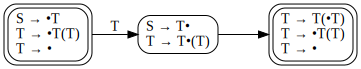

In [34]:
import IHaskell.Display.Graphviz
-- dot "digraph { l -> o; o -> v; v -> e; h -> a ; a -> s; s -> k ; k -> e ; e -> l ; l -> l}"

-- 대략 이런 식으로 프로그램이 자동으로 만들어내도록 
dot $ "digraph { rankdir=LR; node [shape=box style=rounded]; "
   ++ "v0 ["++attrDKnode closS0++"]; "
   ++ "v1 ["++attrDKnode closS0_T++"]; "
   ++ "v2 ["++attrDKnode closS0_Tl++"]; "
   ++ "v0 -> v1 [label=\"T\"];"
   ++ "v1 -> v2 [label=\"⊣\"];"
   ++ "}"
-- 이거는 물론 cfgG55를 그리다 만거다

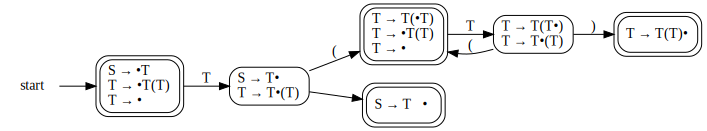

In [35]:
-- DK-test 조건:
-- 모든 테두리 두겹인 상태는
--   1. 점으로 끝나는 규칙(completed rule)은 딱 하나만 있어야
--   2. 점 다음에 alphabet이 오는 규칙은 없어야

-- DK-test를 만족하는 예
drawDK (cfg2graphDK cfgG55)

In [36]:
-- DK-test를 만족하지 않는 예
cfgN1 = CFG(["S","A","B"],["0","1","⊣"],rs,"S")
  where
  rs = [ "S" :-> ["A","⊣"]
       , "A" :-> ["0","A","0"]
       , "A" :-> ["B"]
       , "B" :-> ["1","B","1"]
       , "B" :-> [] -- 2를 알파벳에 추가해서 여기 집어넣으면 어떻게 되나 시험해 보라
       ]

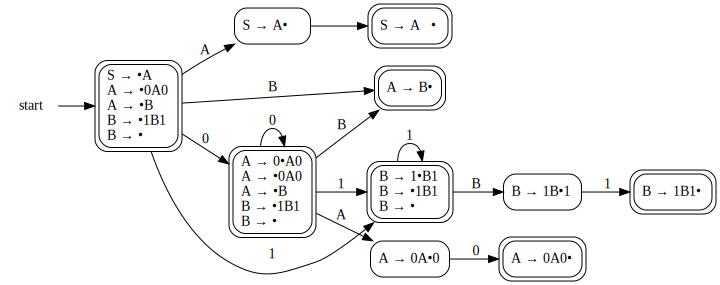

In [37]:
drawDK (cfg2graphDK cfgN1)

In [38]:
-- DK-test를 만족하지 않는 예
cfgG64 = CFG(["S","E","T"],["a","+","×","⊣"],rs,"S")
  where
  rs = [ "S" :-> ["E","⊣"]
       , "E" :-> ["E","+","T"]
       , "E" :-> ["T"]
       , "T" :-> ["T","×","a"]
       , "T" :-> ["a"]
       ]

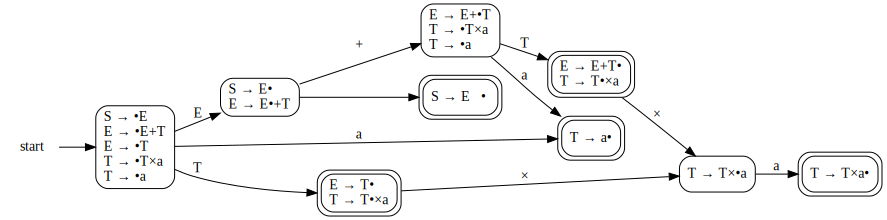

In [39]:
cfgG64DK = cfg2graphDK cfgG64

drawDK cfgG64DK

In [40]:
nullables :: CFG -> [Gamma]
nullables (CFG(_,as,rs,_)) = fix0s ns0
  where
  rs0 = [r | r@(v:->gs) <- rs, all (`notElem` as) gs]
  ns0 = [v | v:->[] <- rs0]
  fix0s ns | ns == ns' = ns
           | otherwise = fix0s ns'
           where
             ns' = ns `union` [v | v:->gs <- rs0, all (`elem` ns) gs]

first :: CFG -> [Gamma] -> [Gamma]
first cfg@(CFG(vs,as,rs,_)) = f1 [] 
  where
  ns = nullables cfg
  f1 ys []        = []
  f1 ys (x:xs)
    | x `elem` as = [x]
    | x `elem` ys = if x `elem` ns then f1' xs else []
    | x `elem` ns = foldr union (f1' xs) [f1' gs | v:->gs <- rs, v==x]
    | otherwise   = foldr union []       [f1' gs | v:->gs <- rs, v==x]
    where
      f1' = f1 (ys `union` [x])

In [41]:
nullables cfgN1
first cfgN1 ["S"]
first cfgN1 ["A"]
first cfgN1 ["B"]

["B","A"]

["0","1","\8867"]

["0","1"]

["1"]

In [42]:
nullables cfgG55

["T"]

In [43]:
first cfgG55 ["S"]
first cfgG55 ["T"]

["(","\8867"]

["("]

In [44]:
nullables cfgG64
first cfgG64 ["S"]
first cfgG64 ["E"]
first cfgG64 ["T"]
first cfgG64 ["+","T"]

[]

["a"]

["a"]

["a"]

["+"]

In [45]:
type DottedRule1 = (DottedRule,Gamma) 
type DottedRule1' = (DottedRule,[Gamma]) 
type NodeDK1 = [DottedRule1]
type EdgeDK1 = (NodeDK1,Gamma,NodeDK1)
type GraphDK1 = ([NodeDK1],[EdgeDK1])

dottedClosure1 :: CFG -> [DottedRule1] -> [DottedRule1] 
dottedClosure1 cfg@(CFG(_,_,rs,_)) drs
  | drs==drs' = drs
  | otherwise = dottedClosure1 cfg drs'
  where
  drs' = drs `union`
         [((v',([],gs')),x') | ((v,(_,v2:gs2)),x) <- drs,
                              v':->gs' <-rs, v2 == v',
                              x' <- first cfg gs2 `union` [x | nullable gs2] ]
  nullable = all (`elem` ns)
  ns = nullables cfg

showDottedRule1 :: DottedRule1 -> String
showDottedRule1 (r,x) = showDottedRule r++"    "++x

showDottedRule1' :: DottedRule1' -> String
showDottedRule1' (r,xs) = showDottedRule r++"   "++concat xs


stepNode1 :: CFG -> NodeDK1 -> Gamma -> NodeDK1
stepNode1 cfg drs g = dottedClosure1 cfg
  [ ((v,(gs1++[g'],gs2)),x) | ((v,(gs1,g':gs2)),x) <- drs, g==g']

cfg2graphDK1 :: CFG -> GraphDK1 
cfg2graphDK1 cfg@(CFG(_,as,rs,s0)) =  mkGraphDK1 cfg ([[],n0],[([],"",n0)])
  where
  n0 = dottedClosure1 cfg [((v,([],gs)),x) | v:->gs <- rs, v==s0, x<-as]

src (n,_,_) = n
dst (_,_,n) = n

mkGraphDK1 :: CFG -> GraphDK1 -> GraphDK1
mkGraphDK1 cfg@(CFG(vs,as,_,_)) (ns,es)
  | (ns,es) == (ns',es')  = (ns,es)
  | otherwise             = mkGraphDK1 cfg (ns',es')
  where
  es' = es `union` esNew
  ns' = ns `union` nsNew
  out0ns = ns \\ map src es
  esNew = [(n,g,n') | n <- out0ns, g<-vs++as,
                      let n' = stepNode1 cfg n g,
                      not(null n')]
  nsNew = map dst esNew

In [46]:
import Data.List (intercalate, elemIndices)

import IHaskell.Display.Graphviz
-- dot "digraph { l -> o; o -> v; v -> e; h -> a ; a -> s; s -> k ; k -> e ; e -> l ; l -> l}"

drawDK1 = dot . cfg2DK1graphviz

cfg2DK1graphviz :: GraphDK1 -> String
cfg2DK1graphviz ([]:ns,([],"",n0):es)
    = "digraph { rankdir=LR; node [shape=box style=rounded]; "
   ++ "start [shape=none]; start -> n0; "
   ++ intercalate "; " [ nodeName n++" ["++attrDK1node n++"]" | n <- ns ]
   ++ intercalate "; " [ nodeName n1++" -> "++nodeName n2
                       ++ " [label=\""++g++"\"]" | (n1,g,n2) <- es ]
   ++ "}"
  where
  nodeName n = "n"++show i where [i] = elemIndices n ns

attrDK1node :: NodeDK1 -> String
attrDK1node drs
    = "peripheries="++(if reducible then "2" else "1")++" "
   ++ "label=\""++concat [showDottedRule1' r++"\\l" | r<-drs']++"\""
  where
  reducible = any null [ gs2 | ((_,(gs1,gs2)),_)<-drs]
  drs' = [(r,xs) | (r:_,xs) <- map unzip . groupBy (\(r1,_) (r2,_) -> r1==r2) $ sort drs]

In [47]:
length $ dottedClosure cfgG64 [("S",([],["E","⊣"]))]
length $ dottedClosure1 cfgG64 [(("S",([],["E","⊣"])),x)|x<-["a","+","×","⊣"]]

5

14

In [48]:
mapM_ (putStrLn . showDottedRule) $ dottedClosure cfgG64 [("S",([],["E","⊣"]))]
putStrLn "---------"
mapM_ (putStrLn . showDottedRule1) $ dottedClosure1 cfgG64  [(("S",([],["E","⊣"])),x)|x<-["a","+","×","⊣"]]

S → •E⊣
E → •E+T
E → •T
T → •T×a
T → •a

---------

S → •E⊣    a
S → •E⊣    +
S → •E⊣    ×
S → •E⊣    ⊣
E → •E+T    ⊣
E → •T    ⊣
E → •E+T    +
E → •T    +
T → •T×a    ⊣
T → •a    ⊣
T → •T×a    +
T → •a    +
T → •T×a    ×
T → •a    ×

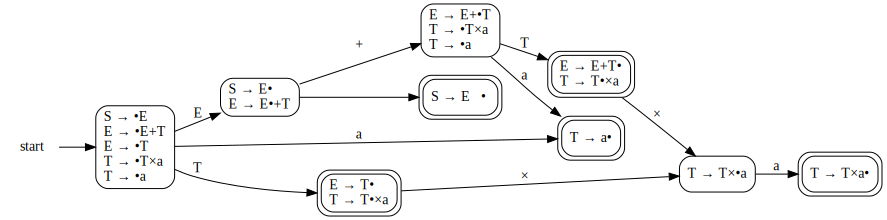

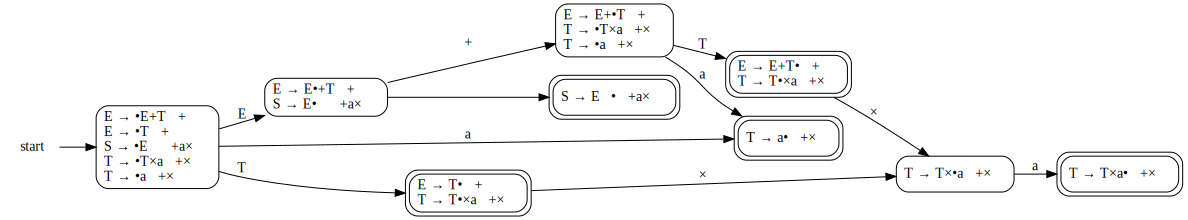

In [49]:
drawDK (cfg2graphDK cfgG64)
drawDK1 (cfg2graphDK1 cfgG64)